In [10]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy import optimize as op
from matplotlib import pyplot as plt

# Data Preprocessing

In [2]:
main_data = pd.read_csv('./04_cricket_1999to2011.csv')

data = main_data[main_data['Innings']==1]
data = data[['Over','Runs','Total.Out']]
# Nx50 Matrix holding history data 
Innings1 = list()

inning = np.zeros(100)
i=0
for d in data.itertuples():
    if d[1]==1 or i==50:
        while i!=50:
            inning[i],inning[i+50] = inning[i-1],inning[50+i-1]
            i+=1
        Innings1.append(inning)
        inning = np.zeros(100)
        i=0
    inning[i],inning[i+50] = inning[i-1]+d[2],d[3]
    i+=1

Innings1 = np.array(Innings1)     
Innings1 = Innings1[1:,:]


## mRSC Algorithm

In [20]:
def mRSC(X,data,intervention_point,k):

    U,S,V = np.linalg.svd(data)
    S_ = np.diag(S[:k])
    M = U[:,:k]@S_@V[:k,:]    

    M_k = np.zeros(shape=(M.shape[0],2*intervention_point))
    M_k[:,:intervention_point],M_k[:,intervention_point:] = M[:,:intervention_point],M[:,50:50+intervention_point] 

    opt_result = op.least_squares(lambda v : X-v@M_k,np.zeros(M_k.shape[0]))
    xopt = opt_result.x
    result = np.int16(np.round(xopt@M))
    return result

## Task 1 : Estimate Deviations in Predictions of 1st Innings

In [42]:
np.random.shuffle(Innings1)
P = int(Innings1.shape[0]*0.9)
train,test = Innings1[:P,:],Innings1[P:,:]

In [51]:
error = np.zeros(50)
for inning in test[np.random.randint(0,test.shape[0],50),:]:
    for intervention_point in range(50):
        Z = np.zeros(2*intervention_point)
        Z[:intervention_point],Z[intervention_point:] = inning[:intervention_point],inning[50:50+intervention_point]
        prediction = mRSC(Z,train,intervention_point,2)
        error[intervention_point] += abs(inning[49]-prediction[49])
error /= 50
plt.plot(error)

KeyboardInterrupt: 

In [26]:
plt.show()

In [27]:
print(error)

[ 49.65834876  28.17388605  79.88796664 145.0241816  144.31207306
 174.45253111 196.21490383 254.44481398 184.3237262   85.04708383
  85.99901791  80.27414389  72.13892088  64.80426673  63.60993215
  76.72739073 108.67471744 124.17343136 121.03177725 107.95678285
  97.84556851  90.2840755   84.69749011  59.48975632  55.22788786
  50.63983159  49.07925221  46.37927349  37.98780115  37.09477444
  32.769537    29.2714139   24.43578626  17.55424099  11.69586134
  12.57326678  13.1971541   12.88868879   9.89218249  10.55067122
   7.60805932   4.81576762   4.79045958   5.4084653    5.61776555
   4.756606     2.74809585   1.53298311   1.17274333   1.02131397]


# Task 2 : Prediction

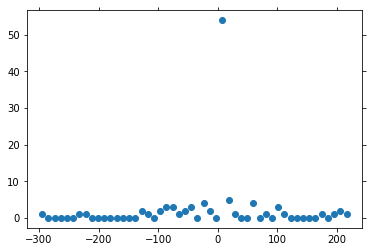

In [52]:
error = np.zeros(100)
i=0
for inning in test[np.random.randint(0,test.shape[0],50),:]:
    intervention_point = 30
    Z = np.zeros(2*intervention_point)
    Z[:intervention_point],Z[intervention_point:] = inning[:intervention_point],inning[50:50+intervention_point]
    prediction = mRSC(Z,train,intervention_point,3)
    error[i] += prediction[49]-inning[49]
    i+=1
er,bin_centers = np.histogram(error,bins=50)
plt.cla()
plt.scatter(bin_centers[1:],er)
plt.show()